In [1]:
!pip install gpboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, make_scorer, classification_report,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)
from gpboost import GPBoostClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("mergedfile_patient_age_yearsall.txt", sep="\t")


In [4]:
mutation_cols = df.columns[1:12941]     
meta_cols_before = df.columns[:1]     
meta_cols_after = df.columns[12941:]    
new_cols = pd.DataFrame(index=df.index)
for col in mutation_cols:
    parts = col.split(',')
    base = parts[0]      
    alleles = parts[1:]  

    col_numeric = pd.to_numeric(df[col], errors='coerce')
    new_cols[base] = col_numeric.apply(lambda x: 1 if x > 0 else 0)
    for i, allele in enumerate(alleles, start=1):
        allele_col = base[:-1] + allele 
        new_cols[allele_col] = col_numeric.apply(lambda x: 1 if x == i else 0)
final_df = pd.concat([df[meta_cols_before], new_cols, df[meta_cols_after]], axis=1)

In [5]:
cols_with_star = [col for col in final_df.columns if '*' in col]
print(cols_with_star[:10]) 

['A1*', 'T2*', 'T3*', 'A4*', 'A5*', 'A6*', 'G7*', 'G8*', 'T9*', 'T10*']


In [6]:
final_df = final_df.drop(columns=cols_with_star)

In [7]:
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29875G,A29876G,A29877T,A29891G,A29892G,Location,Gender,Patient age,Additional host information,Lineage
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Europe / Turkey,Male,87.00,Severe,B
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Slovakia / Okres Presov,Female,91.00,Severe,B.1.1.529
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,South America / Brazil / Rio de Janeiro / Rio ...,Male,35.00,Severe,BA.1
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Asia / China / Fujian,Male,70.00,Severe,EG.5.1.1
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Asia / China / Fujian,Female,19.00,Severe,HK.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Spain / Catalunya / Mataro,Male,94.00,Severe,JN.1.4 (consensus call)
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Spain / Catalunya / Mataro,Female,81.00,Severe,KP.3.1.1 (consensus call)
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,North America / USA / New York / Westchester C...,Male,0.42,Severe,JN.1.4 (consensus call)
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,North America / Mexico / Guanajuato,Female,26.00,Severe,XBB.1.16.15


In [8]:
final_df.drop(columns=['Location', 'Lineage', 'Additional host information'], inplace=True)

In [9]:
metadatatwo = pd.read_csv("metadata2.txt", sep="\t") 
finalfile = pd.merge(final_df, metadatatwo, on="strain")

In [10]:
finalfile

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29877T,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,Male,87.00,19A,B,Europe,Turkey,Severe
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,19.00,23H,HK.3,Asia,China,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe


In [11]:
finalfile['Gender'] = finalfile['Gender'].replace('Hombre', 'Male')  
finalfile['Gender'] = finalfile['Gender'].replace('Mujer', 'Female')
finalfile['Gender'] = finalfile['Gender'].replace('Malex', 'Female')
finalfile['Gender'] = finalfile['Gender'].replace('Famale', 'Female')

In [12]:
finalfile['Gender'].value_counts()


Gender
Female    7856
Male      6121
Name: count, dtype: int64

In [13]:
final_df=finalfile

In [14]:
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29877T,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,Male,87.00,19A,B,Europe,Turkey,Severe
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,19.00,23H,HK.3,Asia,China,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe


In [15]:
final_df['category'] = pd.get_dummies(final_df['category'])['Severe'].astype(int)
print(final_df['category'].head())

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int32


In [16]:
final_df['Gender'] = pd.get_dummies(final_df['Gender'])['Female'].astype(int)
print(final_df['Gender'].head())

0    0
1    1
2    0
3    0
4    1
Name: Gender, dtype: int32


In [17]:
region_dummies = pd.get_dummies(final_df['region'], prefix='region').astype(int)
final_df = pd.concat([final_df, region_dummies], axis=1)
final_df = final_df.drop(['region', 'region_Africa'], axis = 1)

In [18]:
country_dummies = pd.get_dummies(final_df['country'], prefix='country').astype(int)
final_df = pd.concat([final_df , country_dummies], axis=1)
final_df = final_df.drop(['country', 'country_Senegal'], axis = 1)

In [19]:
clade_dummies = pd.get_dummies(final_df ['clade'], prefix='clade').astype(int)
final_df  = pd.concat([final_df , clade_dummies], axis=1)
final_df  = final_df .drop(['clade', 'clade_24C'], axis = 1)

In [20]:
Nextclade_dummies = pd.get_dummies(final_df ['Nextclade_pango'], prefix='Nextclade_pango').astype(int)
final_df  = pd.concat([final_df , Nextclade_dummies], axis=1)

In [21]:
final_df = final_df.drop(['Nextclade_pango', 'Nextclade_pango_XEN'], axis = 1)

In [22]:
first_col = final_df.iloc[:, [0]]
first_col

,strain
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024
3,hCoV-19/Fujian/FCDC-FZ9970725/2024
4,hCoV-19/Fujian/FCDC-XM010309HG/2024
...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024
13974,hCoV-19/USA/NY-WMC-6178/2024
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024


In [23]:
rest = final_df.iloc[:, 1:]
rest

,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,A4T,...,Nextclade_pango_XEL.3,Nextclade_pango_XEP,Nextclade_pango_XEU,Nextclade_pango_XEV,Nextclade_pango_XEW,Nextclade_pango_XFB,Nextclade_pango_XFC,Nextclade_pango_XFG,Nextclade_pango_XFJ,Nextclade_pango_XFL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13973,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13974,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13975,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
filtered_rest = rest.loc[:, (rest.sum(axis=0) >= 10)]
final_df_filtered = pd.concat([first_col, filtered_rest], axis=1)
print("Filtered shape:", final_df_filtered.shape)

Filtered shape: (13977, 9636)


In [25]:
final_df_filtered

,strain,T2G,T3C,A4T,A4C,A5G,A6R,G7T,G8T,T9C,...,Nextclade_pango_XEC.15,Nextclade_pango_XEC.18,Nextclade_pango_XEC.2,Nextclade_pango_XEC.30,Nextclade_pango_XEC.32,Nextclade_pango_XEC.4,Nextclade_pango_XEC.8,Nextclade_pango_XEC.9,Nextclade_pango_XEE,Nextclade_pango_XEK
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13974,hCoV-19/USA/NY-WMC-6178/2024,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X = final_df_filtered.drop(columns=['category', 'strain'])

In [27]:
y = final_df_filtered['category']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int32

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

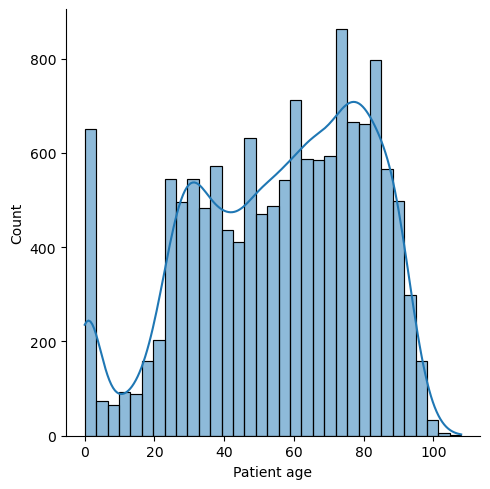

In [29]:
sns.displot(X["Patient age"], kde=True)
plt.show()

In [30]:
X_train.isnull().sum()

T2G                      0
T3C                      0
A4T                      0
A4C                      0
A5G                      0
                        ..
Nextclade_pango_XEC.4    0
Nextclade_pango_XEC.8    0
Nextclade_pango_XEC.9    0
Nextclade_pango_XEE      0
Nextclade_pango_XEK      0
Length: 9634, dtype: int64

In [31]:
X_train["Patient age"].min(), X_train["Patient age"].max(), X_train["Patient age"].mean(), X_train["Patient age"].std()

(0.0, 103.0, 55.55121813791252, 24.976544745874232)

In [32]:
X_test["Patient age"].min(), X_test["Patient age"].max(), X_test["Patient age"].mean(), X_test["Patient age"].std()

(0.04, 108.0, 55.62713519313305, 24.82169200029981)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[["Patient age"]] = scaler.fit_transform(X_train[["Patient age"]]) 
X_test[["Patient age"]] = scaler.transform(X_test[["Patient age"]]) 

In [34]:
pd.DataFrame(X_train).head()

,T2G,T3C,A4T,A4C,A5G,A6R,G7T,G8T,T9C,T10A,...,Nextclade_pango_XEC.15,Nextclade_pango_XEC.18,Nextclade_pango_XEC.2,Nextclade_pango_XEC.30,Nextclade_pango_XEC.32,Nextclade_pango_XEC.4,Nextclade_pango_XEC.8,Nextclade_pango_XEC.9,Nextclade_pango_XEE,Nextclade_pango_XEK
13935,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3065,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
12997,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13399,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7752,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
pd.DataFrame(X_test).head()

,T2G,T3C,A4T,A4C,A5G,A6R,G7T,G8T,T9C,T10A,...,Nextclade_pango_XEC.15,Nextclade_pango_XEC.18,Nextclade_pango_XEC.2,Nextclade_pango_XEC.30,Nextclade_pango_XEC.32,Nextclade_pango_XEC.4,Nextclade_pango_XEC.8,Nextclade_pango_XEC.9,Nextclade_pango_XEE,Nextclade_pango_XEK
2629,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8370,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
11219,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9619,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3678,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [36]:
X_train["Patient age"].min(), X_train["Patient age"].max(), X_train["Patient age"].mean(), X_train["Patient age"].std()

(-2.2242348991472745,
 1.8998185832338077,
 3.7144461949000856e-16,
 1.0000447217191275)

In [37]:
X_test["Patient age"].min(), X_test["Patient age"].max(), X_test["Patient age"].mean(), X_test["Patient age"].std()

(-2.2226333249793595,
 2.1000153542231805,
 0.003039669863634253,
 0.9938445177905502)

In [38]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(11181, 9634)
(2796, 9634)
(11181,)
(2796,)


In [39]:
param_dist = {
    'n_estimators': randint(500, 2100),
    'max_depth': randint(10, 41),
    'num_leaves': randint(10, 41),
    'learning_rate': uniform(0.001, 0.099)  # ~0.001 to 0.1
    }

In [40]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(accuracy_score)

In [41]:
model = GPBoostClassifier()

In [42]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring=scorer,
    cv=cv,
    verbose=2,
    n_jobs=4,
    random_state=42
)


In [43]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GPBoostClassifier(), n_iter=50, n_jobs=4,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A044281FD0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A00FC1B1D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A044280FE0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A044280920>},
                   random_state=42,
                   scoring=make_scorer(accuracy_score, response_method='predict'),
                   verbose=2)

In [44]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]


In [45]:
print("\n Best Parameters Found:", random_search.best_params_)
print("\n Test Set Performance:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))



 Best Parameters Found: {'learning_rate': 0.014951498272501501, 'max_depth': 24, 'n_estimators': 564, 'num_leaves': 34}

 Test Set Performance:
[[ 926  144]
 [ 368 1358]]
              precision    recall  f1-score   support

           0       0.72      0.87      0.78      1070
           1       0.90      0.79      0.84      1726

    accuracy                           0.82      2796
   macro avg       0.81      0.83      0.81      2796
weighted avg       0.83      0.82      0.82      2796

Test ROC AUC: 0.8952542749158012


In [46]:
import pandas as pd
pd.DataFrame(y_pred, columns=['Predicted']).to_csv('y_pred.csv', index=False)

In [47]:
np.save('y_pred.npy', y_pred)

# Classification report
              precision    recall  f1-score   support

           0       0.72      0.87      0.78      1070
           1       0.90      0.79      0.84      1726

    accuracy                           0.82      2796
   macro avg       0.81      0.83      0.81      2796
weighted avg       0.83      0.82      0.82      2796

# Confusion matrix


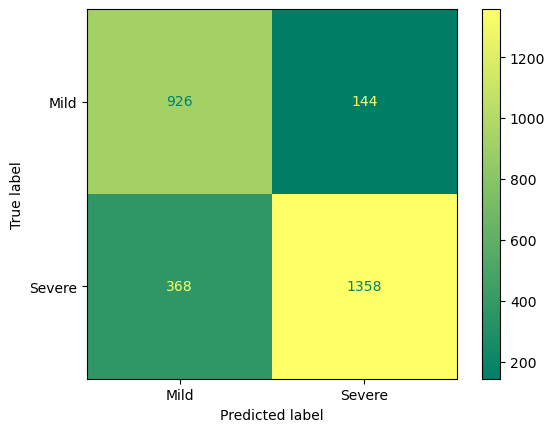

In [48]:
print('# Classification report')
print(classification_report(y_test,y_pred))
print('# Confusion matrix')
cmap = 'summer'
display_labels=['Mild','Severe']
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=cmap)
plt.show()

fpr = [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.34579439e-04 9.34579439e-04 9.34579439e-04 9.34579439e-04
 1.86915888e-03 1.86915888e-03 2.80373832e-03 2.80373832e-03
 3.73831776e-03 3.73831776e-03 4.67289720e-03 4.67289720e-03
 5.60747664e-03 5.60747664e-03 6.54205607e-03 6.54205607e-03
 7.47663551e-03 7.47663551e-03 8.41121495e-03 8.41121495e-03
 9.34579439e-03 9.34579439e-03 1.02803738e-02 1.02803738e-02
 1.12149533e-02 1.12149533e-02 1.21495327e-02 1.21495327e-02
 1.30841121e-02 1.30841121e-02 1.40186916e-02 1.40186916e-02
 1.49532710e-02 1.

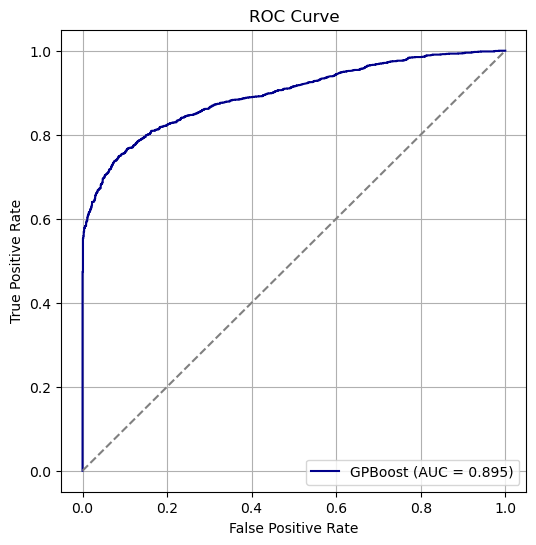

In [49]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
print('fpr =', fpr)
print('tpr =', tpr)
print('thresholds =', thresholds)
print(f"AUC = {auc_score:.3f}")
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"GPBoost (AUC = {auc_score:.3f})", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_GPBoost.tiff', dpi=600, format='tiff')
plt.show()